Tools

In [1]:
import sys  
# sys.path.append('/home/josorior/kinetick/source')
sys.path.append('/home/juanfelipe/Desktop/research/kinetick/source')

In [2]:
# Standard tool packages
import jax
jax.config.update("jax_enable_x64", True)
from jax import grad, jacfwd, hessian
from jax import vmap
import jax.numpy as jnp
from jax.numpy import logical_and
import matplotlib.pyplot as plt
from matplotlib.ticker import StrMethodFormatter
from tqdm import tqdm
from sklearn.metrics import mean_squared_error
# My tools
from models import *
from mykernels import get_gaussianRBF, get_matern_5_2
# Settings
#plt.style.use('seaborn-v0_8')
plt.rcParams["figure.figsize"] = (5, 5)

## PDE

Let $M(x) = \exp\left(-0.5(x_1^2 + x_2^2)\right)$. The Fokker-Planck equation in 2d is given by
$$
\begin{align*}

\partial_t \rho (t,x) &= \text{div}\left(M(x)\nabla\left(\frac{\rho(t,x)}{M(x)}\right)\right) & \text{for } t >0, x \in \Omega = (-3,3)^2 \\
\rho(0,x) &= \rho^0(x), &\text{for } x \in \Omega \\
\nabla\left(\frac{\rho(t,x)}{M(x)} \right)\cdot \mathbf{n} &= 0, & \text{for } t >0, x \in \partial\Omega = (-3,3)^2
\end{align*}
$$
whose analytical solution is known to be
$$
\rho(t, x)=\frac{1}{2 \pi\left(1-e^{-2 t}\right)} e^{-\frac{x_1^2+x_2^2}{2\left(1-e^{-2 t}\right)}}.
$$

We will use the kernel method in closed form since the PDE operator is linear.


- Can we alternate the direction of diffusion ?
- Change to [-5,5] domain

## Kernel solution

Choose a kernel

In [3]:
#k = get_gaussianRBF(0.1)
k = get_matern_5_2(0.5)

First we choose collocation pointsets $\Omega^*\subset\Omega$ and $\Omega^*\subset\partial\Omega$

In [4]:
# \Omega
M_int = 52
pts_int = jnp.linspace(-5,5,M_int)[1:-1].reshape(-1,1)
M_int = pts_int.shape[0]

# \partial\Omega
pts_bdry = jnp.array([-5.,5.]).reshape(-1,1)
M_bdry = pts_bdry.shape[0]

Build the kernel matrix $K(\phi,\phi)$ where $\phi = [\phi_\Omega, \phi_{\partial\Omega}]$ and
$$
\phi_\Omega \left(\square\right) = \delta_{x}\left(\square\right) - h\left(\delta_{x} \circ \text{div}\left(M(x)\nabla\left(\frac{\square}{M(x)}\right)\right)\right) \qquad \text{for } x\in \Omega
$$
$$
\phi_{\partial\Omega} \left(\square\right) = \delta_{x} \circ \nabla\left(\frac{\square}{M(x)}\right) \cdot \mathbf{n} = \qquad \text{for } x\in \partial \Omega
$$
Thus, the matrix has the form
$$
K(\phi,\phi) = 
\begin{pmatrix}
\phi_{\Omega}\left(\phi_{\Omega}\left(K(x,y)\right)\right) & \phi_{\partial\Omega}\left(\phi_{\Omega}\left(K(x,y)\right)\right) \\
\phi_{\Omega}\left(\phi_{\partial\Omega}\left(K(x,y)\right)\right) & \phi_{\partial\Omega}\left(\phi_{\partial\Omega}\left(K(x,y)\right)\right) \\
\end{pmatrix}
$$
where for instance the block $\phi_{\Omega}\left(\phi_{\partial\Omega}\left(K(x,y)\right)\right)$ is evaluated as:

1. Apply $\phi_{\partial\Omega}$ to the function $K(x,y)$ as a function of $x$ only. 

2. Apply $\phi_\Omega$ to $\phi_{\partial\Omega}\left(K(x,y)\right)$ as a function of $y$ only.

Let's compute the blocks.

$$\phi_{\Omega}\left(\phi_{\Omega}\left(K(x,y)\right)\right)$$

In [5]:
def get_M(index):
    @jit
    def M(x,y):
        first = jnp.exp(-(jnp.sum(x**2))/ 2.)
        secnd = jnp.exp(-(jnp.sum(y**2))/ 2.) 
        return jnp.where(index == 0, first, secnd)
    return M
  
def n_aux(z):
    # return jnp.where(z == -5., jnp.array([-1.]), jnp.array([1.]))
    return jnp.array([1.])
    
def get_n(index):
    @jit
    def n(x,y):
        first = n_aux(x)
        secnd = n_aux(y)
        return jnp.where(index == 0, first, secnd)
    return n

def get_fp_sol(d):
    def fp(t,x):
        K = 2*(1-jnp.exp(-2*t))
        return (1/(K*jnp.pi)**(d/2)) * jnp.exp(-(jnp.sum(x**2))/K)
    return fp

fp_sol = get_fp_sol(d=1)

fp_sol = vmap(fp_sol,in_axes=(None,0))

In [6]:
def vectorize_kfunc(k):
    return vmap(vmap(k, in_axes=(None,0)), in_axes=(0,None))

def op_k_apply(k,L_op,R_op):
    return R_op(L_op(k,0),1)

def make_block(k,L_op,R_op):
    return vectorize_kfunc(op_k_apply(k,L_op,R_op))

In [7]:
def get_div(f,g):
    def f_op_g(x,y):
        return f(x,y) / g(x,y)
    return f_op_g

def get_mult(f,g):
    def f_op_g(x,y):
        return f(x,y) * g(x,y)
    return f_op_g

def get_sum(f,g):
    def f_op_g(x,y):
        return f(x,y) + g(x,y)
    return f_op_g

def get_subs(f,g):
    def f_op_g(x,y):
        return f(x,y) - g(x,y)
    return f_op_g

def get_const(h):
    def constant(*args):
        return h
    return constant

def get_dot(f,g):
    def dot_f(x,y):
        return jnp.dot(f(x,y),g(x,y))
    return dot_f

In [8]:
def eval_k(k,index):
    return k

def get_grad(k,index):
    return grad(k,index)

def divergence_k(k,index):
    def divk(*args):
        return jnp.trace(jacfwd(k,index)(*args))
    return divk


h = 1e-3
def phi_omega(k,index):
    return get_subs(eval_k(k,index),
                   get_mult(get_const(h),
                            divergence_k(get_mult(get_M(index),get_grad(get_div(k,get_M(index)),index)),index)))

def phi_pomega(k,index):
    return get_dot(get_n(index),get_grad(get_div(k,get_M(index)),index))


## One step forward

Build $K(\phi,\phi)$

In [10]:
b11 = make_block(k,phi_omega,phi_omega)(pts_int,pts_int)
b12 = make_block(k,phi_omega,phi_pomega)(pts_int,pts_bdry)
b21 = b12.T
b22 = make_block(k,phi_pomega,phi_pomega)(pts_bdry,pts_bdry)

k_pp = jnp.block([[b11,b12],
                  [b21,b22]])
# k_pp = k_pp + 1e-8*jnp.diag(jnp.diag(k_pp))
print('Cond. number:', jnp.linalg.cond(k_pp))

Cond. number: 308127206450961.2


In [11]:
k_pp[-2:,-2:]

Array([[ 2.28015515e+12, -9.73145873e-07],
       [-9.73145873e-07,  2.28015515e+12]], dtype=float64)

Cholesky factorize this ! 

Build $\beta = K(\phi,\phi)z$

In [12]:
# beta
z_star = jnp.concatenate([fp_sol(0.1,pts_int),jnp.zeros(M_bdry)])

beta = jnp.linalg.solve(k_pp,z_star)

Build $\hat \rho(x) = K(x,\phi)^\top\beta$

In [13]:
@jit
def rho_star(x):
    b1 = vmap(vmap(phi_omega(k,1),in_axes=(None,0)),in_axes=(0,None))(x,pts_int)
    b2 = vmap(vmap(phi_pomega(k,1),in_axes=(None,0)),in_axes=(0,None))(x,pts_bdry)
    return jnp.block([[b1,b2]]) @ beta

# Build K(X,phi)
b1 = vmap(vmap(phi_omega(k,1),in_axes=(None,0)),in_axes=(0,None))(pts_int,pts_int)
b2 = vmap(vmap(phi_pomega(k,1),in_axes=(None,0)),in_axes=(0,None))(pts_int,pts_bdry)
k_p = jnp.block([[b1,b2]])

Compute $\hat \rho (X)$ and $\rho (X)$

In [14]:
pred = rho_star(pts_int)
true = fp_sol(0.1+h,pts_int)

NMSE: 0.0


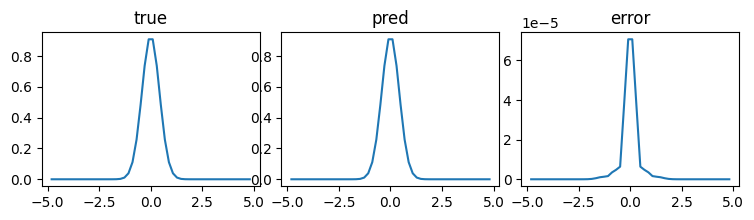

In [15]:
fig, axs = plt.subplots(figsize = (9,2), nrows = 1, ncols = 3, sharex = True, sharey = False)
fig.subplots_adjust(hspace=0.2, wspace=0.1)
# True
axs0 = axs[0].plot(pts_int,true)
axs[0].title.set_text('true')
# Pred
axs1 = axs[1].plot(pts_int,pred)
axs[1].title.set_text('pred')
# Error
axs2 = axs[2].plot(pts_int,jnp.abs(pred-true))
axs[2].title.set_text('error')
# Plot settings
# for i in range(3):
#     axs[i].set_yticklabels([])
#     axs[i].set_xticklabels([])
#     axs[i].set_yticks([])
#     axs[i].set_xticks([])
nmse = mean_squared_error(pred,true)/mean_squared_error(0*pred,true)
print("NMSE:", round(nmse,8))
plt.show()

## Multiple steps

In [16]:
T = 0.2
rho_0 = fp_sol(0.1,pts_int)
steps = int((T-0.1)//h)
previous = rho_0
print('final time:', 0.1 + steps*h)
for _ in tqdm(range(steps)):
    z_star = jnp.concatenate([previous,jnp.zeros(M_bdry)])
    beta = jnp.linalg.solve(k_pp,z_star)
    pred = jnp.dot(k_p, beta)
    #update
    previous = pred

final time: 0.2


100%|██████████| 100/100 [00:00<00:00, 522.45it/s]


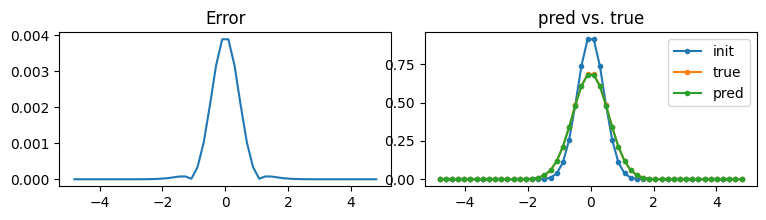

: 

In [17]:
fig, axs = plt.subplots(figsize = (9,2), nrows = 1, ncols = 2, sharex = True, sharey = False)
fig.subplots_adjust(hspace=0.2, wspace=0.1)
# fig.suptitle('t=0.1 | true at t= {} | pred at t={}'.format(final_t,final_t))
# Error
axs0 = axs[0].plot(pts_int,jnp.abs(fp_sol(0.1 + steps*h,pts_int) - pred))
axs[0].title.set_text('Error')
# Init
axs2 = axs[1].plot(pts_int,rho_0,'.-', label = 'init')
# True next
axs1 = axs[1].plot(pts_int,fp_sol(0.1 + steps*h,pts_int),'.-', label = 'true')
# Predicted next
axs[1].plot(pts_int,pred,'.-', label = 'pred')
# legend
axs[1].legend()
axs[1].set_title('pred vs. true')
# Plot settings
# for i in range(3):
#     axs[i].set_yticklabels([])
#     axs[i].set_xticklabels([])
#     axs[i].set_yticks([])
#     axs[i].set_xticks([])
#nmse = mean_squared_error(u_next,fp_1d_sol(final_t, Xfull))/mean_squared_error(0*fp_1d_sol(final_t, Xfull),fp_1d_sol(final_t, Xfull))
plt.show()

## Convergence plots

In [123]:
def get_error(h):
    def phi_omega(k,index):
        return get_subs(eval_k(k,index),
                   get_mult(get_const(h),
                            divergence_k(get_mult(get_M(index),get_grad(get_div(k,get_M(index)),index)),index)))
    b11 = make_block(k,phi_omega,phi_omega)(pts_int,pts_int)
    b21 = make_block(k,phi_omega,phi_pomega)(pts_bdry,pts_int)
    b12 = b21.T
    b22 = make_block(k,phi_pomega,phi_pomega)(pts_bdry,pts_bdry)

    k_pp = jnp.block([[b11,b12],
                    [b21,b22]])
    
    # beta
    z_star = jnp.concatenate([fp_sol(0.1,pts_int),jnp.zeros(pts_bdry.shape[0])])

    beta = jnp.linalg.solve(k_pp,z_star)
    
    def rho_star(x):
        b1 = vmap(vmap(phi_omega(k,1),in_axes=(None,0)),in_axes=(0,None))(x,pts_int)
        b2 = vmap(vmap(phi_pomega(k,1),in_axes=(None,0)),in_axes=(0,None))(x,pts_bdry)
        return jnp.block([[b1,b2]]) @ beta
    
    pred = rho_star(pts_int)
    true = fp_sol(0.1+h,pts_int)

    return mean_squared_error(pred,true)/mean_squared_error(0*pred,true)

As $h$ gets smaller do we get better results ?

In [124]:
h_s = jnp.flip(jnp.power(10,jnp.arange(-8,-1,1,dtype='float64')))

In [125]:
errors = []
for h in tqdm(h_s):
    errors.append(get_error(h))

100%|██████████| 7/7 [00:31<00:00,  4.50s/it]


In [19]:
errors

[0.30544573339468284,
 0.0006554829326562041,
 2.0250771547637012e-06,
 1.6935364383600667e-08,
 1.6618381625763765e-10,
 1.6586831217740648e-12,
 1.6583685979928043e-14]

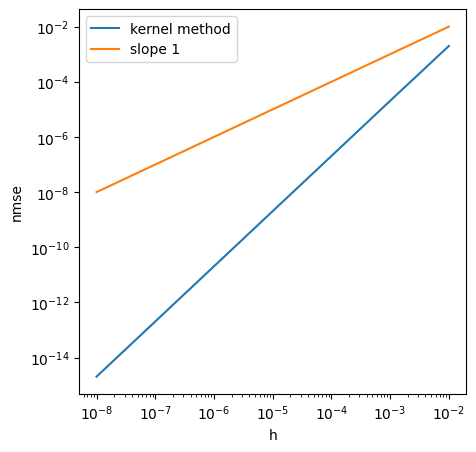

In [126]:
plt.loglog(h_s,errors,label ='kernel method')
plt.loglog(h_s,h_s, label='slope 1')
plt.xlabel('h')
plt.ylabel('nmse')
plt.legend()
plt.show()

In [127]:
slope, ycut = jnp.polyfit(jnp.array(h_s),jnp.array(errors), deg=1)

In [128]:
slope

Array(0.20048199, dtype=float64)

## Convergence plot

In [129]:
norms = []
for n in tqdm(jnp.arange(100,2000,100)):
    # \Omega
    pts_int = jnp.linspace(-5,5,n)[1:-1].reshape(-1,1)
    M_int = pts_int.shape[0]

    # \partial\Omega
    pts_bdry = jnp.array([-5.,5.]).reshape(-1,1)
    M_bdry = pts_bdry.shape[0]

    h = 1e-2
    def phi_omega(k,index):
        return get_subs(eval_k(k,index),
                   get_mult(get_const(h),
                            divergence_k(get_mult(get_M(index),get_grad(get_div(k,get_M(index)),index)),index)))
    
    b11 = make_block(k,phi_omega,phi_omega)(pts_int,pts_int)
    b21 = make_block(k,phi_omega,phi_pomega)(pts_bdry,pts_int)
    b12 = b21.T
    b22 = make_block(k,phi_pomega,phi_pomega)(pts_bdry,pts_bdry)

    k_pp = jnp.block([[b11,b12],[b21,b22]])

    # Build K(X,phi)
    b1 = vmap(vmap(phi_omega(k,1),in_axes=(None,0)),in_axes=(0,None))(pts_int,pts_int)
    b2 = vmap(vmap(phi_pomega(k,1),in_axes=(None,0)),in_axes=(0,None))(pts_int,pts_bdry)
    k_p = jnp.block([[b1,b2]])

    # beta
    T = 0.2
    previous = fp_sol(0.1,pts_int)
    steps = int((T-0.1)//h)
    print('final time:', 0.1 + steps*h)
    for _ in tqdm(range(steps)):
        z_star = jnp.concatenate([previous,jnp.zeros(pts_bdry.shape[0])])
        beta = jnp.linalg.solve(k_pp,z_star)
        pred = k_p @ beta
        #update
        previous = pred.copy()
    
    true = fp_sol(T,pts_int)
    print(n)
    norms.append(mean_squared_error(pred,true)/mean_squared_error(0*pred,true))

  0%|          | 0/19 [00:00<?, ?it/s]

final time: 0.2


  5%|▌         | 1/19 [00:04<01:29,  4.95s/it]

100
final time: 0.2


 11%|█         | 2/19 [00:19<03:02, 10.72s/it]

200
final time: 0.2


 16%|█▌        | 3/19 [00:34<03:19, 12.44s/it]

300
final time: 0.2


 21%|██        | 4/19 [00:49<03:20, 13.39s/it]

400
final time: 0.2


 26%|██▋       | 5/19 [01:04<03:17, 14.11s/it]

500
final time: 0.2


 32%|███▏      | 6/19 [01:20<03:12, 14.79s/it]

600
final time: 0.2


 37%|███▋      | 7/19 [01:36<03:03, 15.30s/it]

700
final time: 0.2


 42%|████▏     | 8/19 [01:53<02:53, 15.78s/it]

800
final time: 0.2


 47%|████▋     | 9/19 [02:10<02:39, 15.95s/it]

900
final time: 0.2


 53%|█████▎    | 10/19 [02:26<02:24, 16.11s/it]

1000
final time: 0.2


 58%|█████▊    | 11/19 [02:43<02:09, 16.25s/it]

1100
final time: 0.2


 63%|██████▎   | 12/19 [03:00<01:55, 16.57s/it]

1200
final time: 0.2


 68%|██████▊   | 13/19 [03:17<01:40, 16.82s/it]

1300
final time: 0.2


 74%|███████▎  | 14/19 [03:34<01:24, 16.84s/it]

1400
final time: 0.2


 79%|███████▉  | 15/19 [03:53<01:09, 17.32s/it]

1500
final time: 0.2


 84%|████████▍ | 16/19 [04:11<00:52, 17.51s/it]

1600
final time: 0.2


 89%|████████▉ | 17/19 [04:29<00:35, 17.75s/it]

1700
final time: 0.2


 95%|█████████▍| 18/19 [04:47<00:17, 17.87s/it]

1800
final time: 0.2


100%|██████████| 19/19 [05:05<00:00, 16.09s/it]

1900


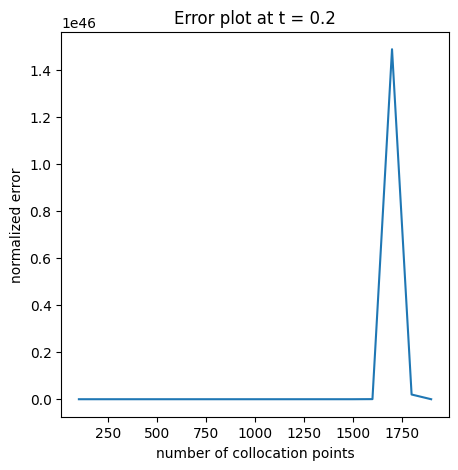

In [130]:
Ns = [n for n in jnp.arange(100,2000,100)]
plt.plot(Ns,norms)
plt.xlabel('number of collocation points')
plt.ylabel('normalized error')
plt.title('Error plot at t = 0.2')
plt.show()

In [131]:
norms

[0.1238073655215066,
 0.12394624756097476,
 0.12394624756097575,
 66577.11857381434,
 7.525508614690207e+18,
 6.401471882806593e+30,
 7593950423861.072,
 45696550136.734764,
 17110055730.343988,
 1820472.647719719,
 2.8169732174002764e+27,
 1.5235678972256727e+19,
 5.440457683065251e+31,
 4.1345670984142706e+24,
 1.811226853677118e+27,
 4.143783656933834e+42,
 1.489047133603226e+46,
 2.0024732510346997e+44,
 7.423425084801125e+37]

- The kernel matrix is ill-conditioned, and every iteration of the time-stepping when we solve for the linear system
$$
\beta = K(\phi,\phi)^{-1} z
$$
will lead to very different results.
- Experiments show convergence of the method but since we have such an ill-conditioned matrix, we might want to switched to the method of lines approach now.
